In [1]:
import numpy
import numpy as np
import os
import pandas
import cv2
from tqdm import tqdm
import random

In [2]:
IMG_SIZE = 128
sigmaX = 30

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[numpy.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][numpy.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][numpy.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][numpy.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][numpy.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = numpy.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [3]:
aptos_df = pandas.read_csv("../input/aptos2019-blindness-detection/train.csv")
dr_df = pandas.read_csv("../input/diabetic-retinopathy-resized/trainLabels.csv")

In [4]:
aptos_dir = "../input/aptos2019-blindness-detection/train_images/"
dr_dir = "../input/diabetic-retinopathy-resized/resized_train/resized_train/"

images = []
labels = []
count0 = 0

# for idx in tqdm(range(len(dr_df))):
#     if dr_df.iloc[idx]['level'] == 0:
#         if count0 < 6038:
#             images.append(load_ben_color(dr_dir+dr_df.iloc[idx]['image']+'.jpeg'))
#             labels.append(dr_df.iloc[idx]['level'])
#             count0 += 1
#     else:
#         images.append(load_ben_color(dr_dir+dr_df.iloc[idx]['image']+'.jpeg'))
#         labels.append(dr_df.iloc[idx]['level'])

for idx in tqdm(range(len(aptos_df))):
    images.append(load_ben_color(aptos_dir+aptos_df.iloc[idx]['id_code']+'.png'))
    labels.append(aptos_df.iloc[idx]['diagnosis'])

100%|██████████| 3662/3662 [11:55<00:00,  5.12it/s]


In [6]:
images = numpy.array(images)
labels = numpy.array(labels)
cat_labels = to_categorical(labels)

In [7]:
from sklearn.model_selection import train_test_split
images = images.astype('float32') / 255.0
X_train, X_test, y_train, y_test = train_test_split(images, cat_labels, test_size=0.1, random_state=42, shuffle=True, stratify=cat_labels)

In [5]:
from keras.models import Sequential,Model
from keras.utils import to_categorical
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Activation
from keras import losses
from keras.optimizers import Adam, Adagrad
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.model_selection import GridSearchCV
import keras

In [15]:
def Randomized_Model(lr=0.01,dropout=0.5,optimizer="adam",loss='categorical_crossentropy',
                    last_activation="softmax",activation="relu",clipnorm=0.1,
                    decay=1e-2,momentum=0.5,l1=0.01,l2=0.001,No_of_CONV_and_Maxpool_layers=3,
                    No_of_Dense_Layers=3,No_of_Units_in_dense_layers=24,Conv2d_filters=60):
    
    model=Sequential()
    
    for i in range(0,No_of_CONV_and_Maxpool_layers):
        model.add(Conv2D(Conv2d_filters, (2,2) ,padding="same"))
        model.add(Activation(activation))
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Flatten())
    
    for i in range (0,No_of_Dense_Layers):
        model.add(Dense(units=No_of_Units_in_dense_layers,activation=activation, kernel_regularizer=regularizers.l2(l2),
                  activity_regularizer=regularizers.l1(l1)))
    
    model.add(Dropout(dropout))
    model.add(Dense(units=20,activation=activation))
    
    model.add(Dense(units=5,activation=last_activation))
    if optimizer=="Adam":
        opt=keras.optimizers.Adam(lr=lr, decay=decay, beta_1=0.9, beta_2=0.999)
    if optimizer=="Adagrad":
        opt=keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=decay)
    if optimizer=="sgd":
        opt=keras.optimizers.SGD(lr=lr, momentum=momentum, decay=decay, nesterov=False)
    
    model.compile(loss=loss,optimizer=opt,
                 metrics=['accuracy'])

    return model

In [18]:
params = {'lr': (0.1, 0.01,1,0.001 ),
     'epochs': [10,5,15,30],
     'dropout': (0, 0.40, 0.8),
     'optimizer': ["Adam","Adagrad","sgd"],
     'loss': ["categorical_crossentropy"],#,"mean_squared_error","mean_absolute_error"],
     'last_activation': ["softmax"],#,"sigmoid"],
     'activation': ["relu","selu","tanh"],
     'clipnorm':(0.0,0.5,1),
     'decay':(1e-6,1e-4,1e-2),
     'momentum':(0.9,0.5,0.2),
     'l1': (0.01,0.001,0.0001),
     'l2': (0.01,0.001,0.0001),
     'No_of_CONV_and_Maxpool_layers':[2,3],
     'No_of_Dense_Layers': [2,3,4,5],
     'No_of_Units_in_dense_layers':[128,64,32,256],
     
     'Conv2d_filters':[60,40,80,120,220]
    }

In [19]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer
# model class to use in the scikit random search CV 
model = KerasClassifier(build_fn=Randomized_Model, epochs=10, batch_size=20, verbose=1)
grid = RandomizedSearchCV(estimator=model, cv=KFold(3), param_distributions=params, 
                          verbose=20,  n_iter=10, n_jobs=1)

In [20]:
grid_result = grid.fit(X_train, y_train)
best_params=grid_result.best_params_
best_params

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START Conv2d_filters=220, No_of_CONV_and_Maxpool_layers=3, No_of_Dense_Layers=2, No_of_Units_in_dense_layers=256, activation=tanh, clipnorm=0.5, decay=0.01, dropout=0.4, epochs=15, l1=0.0001, l2=0.01, last_activation=softmax, loss=categorical_crossentropy, lr=0.1, momentum=0.2, optimizer=sgd
Epoch 1/15
110/110 [==============================] - 6s 44ms/step - loss: 8.3182 - accuracy: 0.4677
Epoch 2/15
110/110 [==============================] - 5s 42ms/step - loss: 6.3103 - accuracy: 0.5032
Epoch 3/15
110/110 [==============================] - 5s 42ms/step - loss: 5.1664 - accuracy: 0.6376
Epoch 4/15
110/110 [==============================] - 5s 42ms/step - loss: 4.5340 - accuracy: 0.6827
Epoch 5/15
110/110 [==============================] - 5s 42ms/step - loss: 4.1605 - accuracy: 0.6841
Epoch 6/15
110/110 [==============================] - 5s 42ms/step - loss: 3.8258 - accuracy: 0.6954
Epoch 7/15
110/110 [=====

55/55 [==============================] - 1s 6ms/step - loss: 130.4922 - accuracy: 0.4877
[CV 1/3; 2/10] END Conv2d_filters=60, No_of_CONV_and_Maxpool_layers=3, No_of_Dense_Layers=3, No_of_Units_in_dense_layers=256, activation=selu, clipnorm=0.5, decay=0.01, dropout=0.4, epochs=10, l1=0.0001, l2=0.0001, last_activation=softmax, loss=categorical_crossentropy, lr=0.1, momentum=0.5, optimizer=Adam; total time=  14.8s
[CV 2/3; 2/10] START Conv2d_filters=60, No_of_CONV_and_Maxpool_layers=3, No_of_Dense_Layers=3, No_of_Units_in_dense_layers=256, activation=selu, clipnorm=0.5, decay=0.01, dropout=0.4, epochs=10, l1=0.0001, l2=0.0001, last_activation=softmax, loss=categorical_crossentropy, lr=0.1, momentum=0.5, optimizer=Adam
Epoch 1/10
110/110 [==============================] - 2s 12ms/step - loss: 23467830.7186 - accuracy: 0.3432
Epoch 2/10
110/110 [==============================] - 1s 11ms/step - loss: 10424.2039 - accuracy: 0.4760
Epoch 3/10
110/110 [==============================] - 2s 15m

110/110 [==============================] - 2s 17ms/step - loss: 2280.4964 - accuracy: 0.4932
Epoch 4/15
110/110 [==============================] - 2s 18ms/step - loss: 2236.2265 - accuracy: 0.4889
Epoch 5/15
110/110 [==============================] - 2s 17ms/step - loss: 2205.9664 - accuracy: 0.4963
Epoch 6/15
110/110 [==============================] - 2s 17ms/step - loss: 2183.3594 - accuracy: 0.5024
Epoch 7/15
110/110 [==============================] - 2s 17ms/step - loss: 2165.4452 - accuracy: 0.4979
Epoch 8/15
110/110 [==============================] - 2s 17ms/step - loss: 2150.7224 - accuracy: 0.4983
Epoch 9/15
110/110 [==============================] - 2s 17ms/step - loss: 2138.3247 - accuracy: 0.4822
Epoch 10/15
110/110 [==============================] - 2s 18ms/step - loss: 2127.5613 - accuracy: 0.4952
Epoch 11/15
110/110 [==============================] - 2s 17ms/step - loss: 2118.1878 - accuracy: 0.4917
Epoch 12/15
110/110 [==============================] - 2s 17ms/step - los

110/110 [==============================] - 4s 41ms/step - loss: 4.1770 - accuracy: 0.7329
Epoch 5/5
55/55 [==============================] - 1s 15ms/step - loss: 3.8726 - accuracy: 0.7295
[CV 2/3; 5/10] END Conv2d_filters=220, No_of_CONV_and_Maxpool_layers=3, No_of_Dense_Layers=5, No_of_Units_in_dense_layers=64, activation=tanh, clipnorm=0.0, decay=0.0001, dropout=0.4, epochs=5, l1=0.01, l2=0.01, last_activation=softmax, loss=categorical_crossentropy, lr=0.01, momentum=0.2, optimizer=sgd; total time=  25.1s
[CV 3/3; 5/10] START Conv2d_filters=220, No_of_CONV_and_Maxpool_layers=3, No_of_Dense_Layers=5, No_of_Units_in_dense_layers=64, activation=tanh, clipnorm=0.0, decay=0.0001, dropout=0.4, epochs=5, l1=0.01, l2=0.01, last_activation=softmax, loss=categorical_crossentropy, lr=0.01, momentum=0.2, optimizer=sgd
Epoch 1/5
110/110 [==============================] - 6s 41ms/step - loss: 5.2652 - accuracy: 0.5412
Epoch 2/5
110/110 [==============================] - 5s 42ms/step - loss: 4.7220

Epoch 1/5
110/110 [==============================] - 5s 40ms/step - loss: 1.5680 - accuracy: 0.4053
Epoch 2/5
110/110 [==============================] - 4s 40ms/step - loss: 1.4201 - accuracy: 0.4999
Epoch 3/5
110/110 [==============================] - 4s 41ms/step - loss: 1.4024 - accuracy: 0.4970
Epoch 4/5
110/110 [==============================] - 4s 40ms/step - loss: 1.3987 - accuracy: 0.4977
Epoch 5/5
55/55 [==============================] - 1s 14ms/step - loss: 1.3482 - accuracy: 0.4991
[CV 2/3; 7/10] END Conv2d_filters=220, No_of_CONV_and_Maxpool_layers=2, No_of_Dense_Layers=3, No_of_Units_in_dense_layers=128, activation=tanh, clipnorm=0.0, decay=1e-06, dropout=0.8, epochs=5, l1=0.0001, l2=0.0001, last_activation=softmax, loss=categorical_crossentropy, lr=0.1, momentum=0.9, optimizer=Adagrad; total time=  24.8s
[CV 3/3; 7/10] START Conv2d_filters=220, No_of_CONV_and_Maxpool_layers=2, No_of_Dense_Layers=3, No_of_Units_in_dense_layers=128, activation=tanh, clipnorm=0.0, decay=1e-0

110/110 [==============================] - 1s 14ms/step - loss: 46349.0238 - accuracy: 0.3472
Epoch 4/10
110/110 [==============================] - 2s 14ms/step - loss: 47858.5387 - accuracy: 0.3647
Epoch 5/10
110/110 [==============================] - 2s 15ms/step - loss: 38067.4750 - accuracy: 0.3823
Epoch 6/10
110/110 [==============================] - 2s 14ms/step - loss: 43045.7475 - accuracy: 0.3685
Epoch 7/10
110/110 [==============================] - 2s 14ms/step - loss: 38637.4508 - accuracy: 0.3608
Epoch 8/10
110/110 [==============================] - 1s 14ms/step - loss: 35543.0042 - accuracy: 0.3585
Epoch 9/10
110/110 [==============================] - 1s 14ms/step - loss: 36021.6059 - accuracy: 0.3895
Epoch 10/10
55/55 [==============================] - 1s 6ms/step - loss: 12230.5166 - accuracy: 0.4991
[CV 2/3; 9/10] END Conv2d_filters=80, No_of_CONV_and_Maxpool_layers=2, No_of_Dense_Layers=2, No_of_Units_in_dense_layers=64, activation=selu, clipnorm=1, decay=0.01, dropout

165/165 [==============================] - 8s 44ms/step - loss: 7.9549 - accuracy: 0.4791
Epoch 2/15
165/165 [==============================] - 7s 42ms/step - loss: 5.3230 - accuracy: 0.6866
Epoch 3/15
165/165 [==============================] - 7s 42ms/step - loss: 4.3753 - accuracy: 0.7143
Epoch 4/15
165/165 [==============================] - 7s 42ms/step - loss: 3.8446 - accuracy: 0.7261
Epoch 5/15
165/165 [==============================] - 7s 42ms/step - loss: 3.5064 - accuracy: 0.7345
Epoch 6/15
165/165 [==============================] - 7s 42ms/step - loss: 3.2758 - accuracy: 0.7221
Epoch 7/15
165/165 [==============================] - 7s 42ms/step - loss: 3.0723 - accuracy: 0.7270
Epoch 8/15
165/165 [==============================] - 7s 42ms/step - loss: 2.8638 - accuracy: 0.7532
Epoch 9/15
165/165 [==============================] - 7s 42ms/step - loss: 2.7448 - accuracy: 0.7511
Epoch 10/15
165/165 [==============================] - 7s 42ms/step - loss: 2.6165 - accuracy: 0.7538


{'optimizer': 'sgd',
 'momentum': 0.2,
 'lr': 0.1,
 'loss': 'categorical_crossentropy',
 'last_activation': 'softmax',
 'l2': 0.01,
 'l1': 0.0001,
 'epochs': 15,
 'dropout': 0.4,
 'decay': 0.01,
 'clipnorm': 0.5,
 'activation': 'tanh',
 'No_of_Units_in_dense_layers': 256,
 'No_of_Dense_Layers': 2,
 'No_of_CONV_and_Maxpool_layers': 3,
 'Conv2d_filters': 220}

In [23]:
from sklearn.metrics import accuracy_score

y=grid_result.predict(X_test)
yy = to_categorical(y)
random=accuracy_score(yy, y_test)
print("Base Accuracy ",random)

best_random = grid_result.best_estimator_
y1=best_random.predict(X_test)
y1y1 = to_categorical(y1)
Best=accuracy_score(y1y1, y_test)
print("Best Accuracy " ,Best)

print('Improvement of {:0.2f}%.'.format( 100 * (Best - random) / random))

 5/19 [======>.......................] - ETA: 0s

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


19/19 [==============================] - 0s 15ms/step
Base Accuracy  0.7493188010899182
 5/19 [======>.......................] - ETA: 0s

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


19/19 [==============================] - 0s 14ms/step
Best Accuracy  0.7493188010899182
Improvement of 0.00%.


In [24]:
def Best_param_Model(best_params):
       
    lr=best_params["lr"]
    dropout=best_params["dropout"]
    optimizer=best_params["optimizer"]
    loss=best_params["loss"]
    last_activation=best_params["last_activation"]
    activation=best_params["activation"]
    clipnorm=best_params["clipnorm"]
    decay=best_params["decay"]
    momentum=best_params["momentum"]
    l1=best_params["l1"]
    l2=best_params["l2"]
    No_of_CONV_and_Maxpool_layers=best_params["No_of_CONV_and_Maxpool_layers"]
    No_of_Dense_Layers=best_params["No_of_Dense_Layers"]
    No_of_Units_in_dense_layers=best_params["No_of_Units_in_dense_layers"]
    Conv2d_filters=best_params["Conv2d_filters"]
    
    #model sequential
    model=Sequential()
    
    for i in range(0,No_of_CONV_and_Maxpool_layers):
        model.add(Conv2D(Conv2d_filters, (2,2) ,padding="same"))
        model.add(Activation(activation))
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    
    model.add(Flatten())
    
    for i in range (0,No_of_Dense_Layers):
        model.add(Dense(units=No_of_Units_in_dense_layers,activation=activation, kernel_regularizer=regularizers.l2(l2),
                  activity_regularizer=regularizers.l1(l1)))
    
    
    model.add(Dense(units=20,activation=activation))
    
    model.add(Dense(units=5,activation=last_activation))
    if optimizer=="Adam":
        opt=keras.optimizers.Adam(lr=lr, decay=decay, beta_1=0.9, beta_2=0.999)
    if optimizer=="Adagrad":
        opt=keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=decay)
    if optimizer=="sgd":
        opt=keras.optimizers.SGD(lr=lr, momentum=momentum, decay=decay, nesterov=False)
    
    model.compile(loss=loss,optimizer=opt,
                 metrics=['accuracy'])
    
    return model

In [26]:
Binary_model=Best_param_Model(best_params)
history =Binary_model.fit(X_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
93/93 [==============================] - 8s 73ms/step - loss: 8.4569 - accuracy: 0.4572 - val_loss: 6.6284 - val_accuracy: 0.6545
Epoch 2/10
93/93 [==============================] - 6s 67ms/step - loss: 6.2452 - accuracy: 0.6619 - val_loss: 5.3514 - val_accuracy: 0.7303
Epoch 3/10
93/93 [==============================] - 6s 67ms/step - loss: 5.2532 - accuracy: 0.6845 - val_loss: 4.7237 - val_accuracy: 0.7242
Epoch 4/10
93/93 [==============================] - 6s 67ms/step - loss: 4.6509 - accuracy: 0.7050 - val_loss: 4.3144 - val_accuracy: 0.7576
Epoch 5/10
93/93 [==============================] - 6s 68ms/step - loss: 4.2632 - accuracy: 0.7175 - val_loss: 3.9911 - val_accuracy: 0.7455
Epoch 6/10
93/93 [==============================] - 6s 67ms/step - loss: 3.9285 - accuracy: 0.7347 - val_loss: 3.7611 - val_accuracy: 0.7333
Epoch 7/10
93/93 [==============================] - 6s 67ms/step - loss: 3.7321 - accuracy: 0.7283 - val_loss: 3.5661 - val_accuracy: 0.7333
Epoch 8/10
93

NameError: name 'plt' is not defined

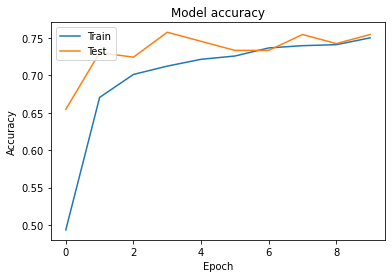

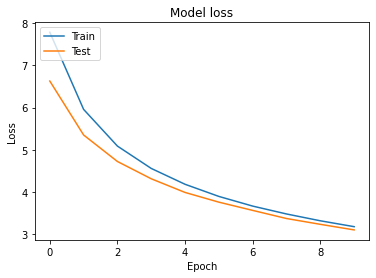

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])


plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
Binary_model.evaluate(X_test,y_test)

12/12 [==============================] - 0s 23ms/step - loss: 3.1460 - accuracy: 0.7275


[3.146049976348877, 0.7275204062461853]